In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.0'

In [2]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    #print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    config.gpu_options.visible_device_list = "0"
    #config.gpu_options.allow_growth = True
    set_session(tensorflow.Session(config=config))

reset_keras()

# 컨브넷의 학습 시각화하기

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 5장 4절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

딥러닝 모델을 '블랙 박스' 같다고 자주 이야기합니다. 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내거나 제시하기 어렵기 때문입니다. 일부 딥러닝 모델에서는 이 말이 어느정도 맞지만 컨브넷에서는 전혀 아닙니다. 컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다. 2013년부터 이런 표현들을 시각화하고 해석하는 다양한 기법들이 개발되었습니다. 여기서 모두를 다룰 수는 없지만 가장 사용이 편하고 유용한 세 가지 기법을 다루겠습니다.

* 컨브넷 중간 층의 출력(중간 층에 있는 활성화)을 시각화하기 : 연속된 컨브넷층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 됩니다.
* 컨브넷 필터를 시각화하기 : 컨브넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해하는 데 도움이 됩니다.
* 클래스 활성화에 대한 히트맵을 이미지에 시각화하기 : 이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해하고 이미지에서 객체의 위치를 추정하는 데 도움이 됩니다.

첫 번째 방법인 활성화 출력을 시각화하는 기법을 위해서 5.2절에 있는 강아지 vs. 고양이 분류 문제에서 처음부터 훈련시킨 작은 컨브넷을 사용하겠습니다. 다른 두 가지 방법을 위해서는 5.3절에 소개된 VGG16 모델을 사용하겠습니다.

## 중간 층의 활성화 시각화하기

중간 층의 활성화 시각화는 어떤 입력이 주어졌을 때 네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성 맵을 그리는 것입니다(층의 출력이 활성화 함수의 출력이라서 종종 활성화(activation)라고 부릅니다). 이 방법은 네트워크에의해 학습된 필터들이 어떻게 입력을 분해하는지 보여줍니다. 넓이, 높이, 깊이(채널)의 세 개 차원에 대해 특성 맵을 시각화하는 것이 좋습니다. 각 채널은 비교적 독립적인 특성을 인코딩하므로 특성 맵의 각 채널 내용을 독립적인 2D 이미지로 그리는 것이 괜찮은 방법입니다. 5.2절에서 저장했던 모델을 로드하여 시작해 보죠:

In [3]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         


그다음 네트워크를 훈련할 때 사용했던 이미지에 포함되지 않은 고양이 사진 하나를 입력 이미지로 선택합니다:

In [4]:
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 이미지를 4D 텐서로 변경합니다
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
img_tensor /= 255.

# 이미지 텐서의 크기는 (1, 150, 150, 3)입니다
print(img_tensor.shape)

(1, 150, 150, 3)


사진을 출력해 보죠:

In [5]:
import matplotlib.pyplot as plt

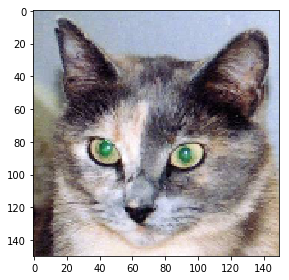

In [5]:
plt.imshow(img_tensor[0])
plt.show()

확인하고 싶은 특성 맵을 추출하기 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링 층의 활성화를 출력하는 케라스 모델을 만들 것입니다. 이를 위해 케라스의 `Model` 클래스를 사용하겠습니다. 모델 인스턴스를 만들 때 두 개의 매개변수가 필요합니다. 입력 텐서(또는 입력 텐서의 리스트)와 출력 텐서(또는 출력 텐서의 리스트)입니다. 반환되는 객체는 `Sequential`과 같은 케라스 모델이지만 특정 입력과 특정 출력을 매핑합니다. `Model` 클래스를 사용하면 `Sequential`과는 달리 여러 개의 출력을 가진 모델을 만들 수 있습니다. `Model` 클래스에 대해 더 자세한 내용은 7.1절을 참고하세요.

In [6]:
from keras import models

# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

입력 이미지가 주입될 때 이 모델은 원본 모델의 활성화 값을 반환합니다. 이 모델이 이 책에서는 처음 나오는 다중 출력 모델입니다. 지금까지 본 모델은 정확히 하나의 입력과 하나의 출력만을 가졌습니다. 일반적으로 모델은 몇 개의 입력과 출력이라도 가질 수 있습니다. 이 모델은 하나의 입력과 층의 활성화마다 하나씩 총 8개의 출력을 가집니다.

In [7]:
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

예를 들어 다음이 고양이 이미지에 대한 첫 번째 합성곱 층의 활성화 값입니다:

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


32개의 채널을 가진 148 × 148 크기의 특성 맵입니다. 원본 모델의 첫 번째 층의 활성화 중에서 스무 번째 채널을 그려 보겠습니다:

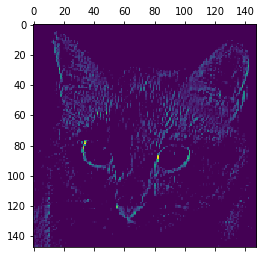

In [9]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

이 채널은 대각선 에지를 감지하도록 인코딩된 것 같습니다. 열여섯 번째 채널을 그려보죠. 합성곱 층이 학습한 필터는 결정적이지 않기 때문에 채널 이미지가 각자 다를 수 있습니다.

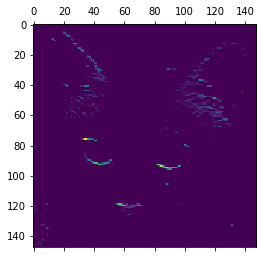

In [10]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.show()

이 채널은 '밝은 녹색 점'을 감지하는 것 같아 고양이 눈을 인코딩하기 좋습니다. 이제 네트워크의 모든 활성화를 시각화해 보겠습니다. 8개의 활성화 맵에서 추출한 모든 채널을 그리기 위해 하나의 큰 이미지 텐서에 추출한 결과를 나란히 쌓겠습니다.

/home/haesun/anaconda3/envs/deep-learning-with-python/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


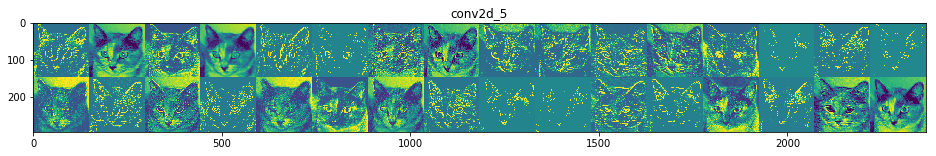

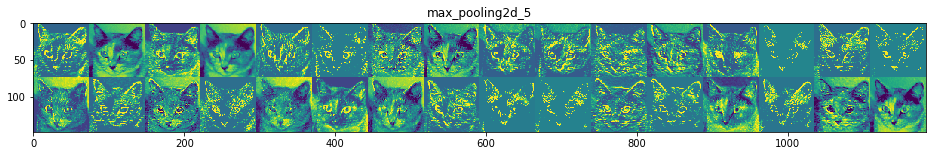

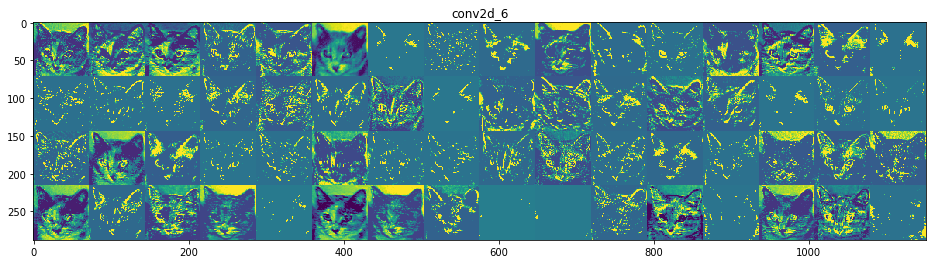

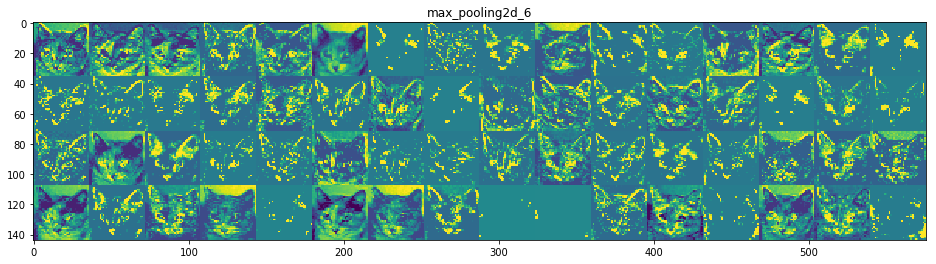

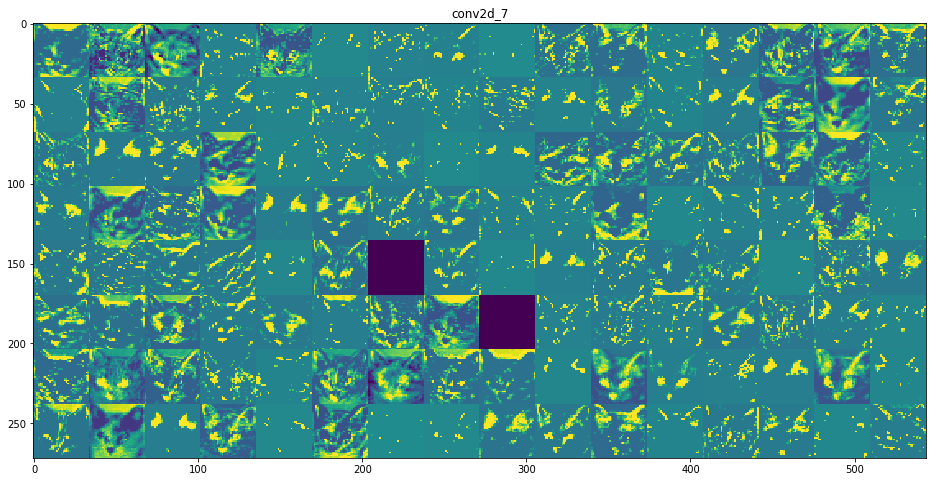

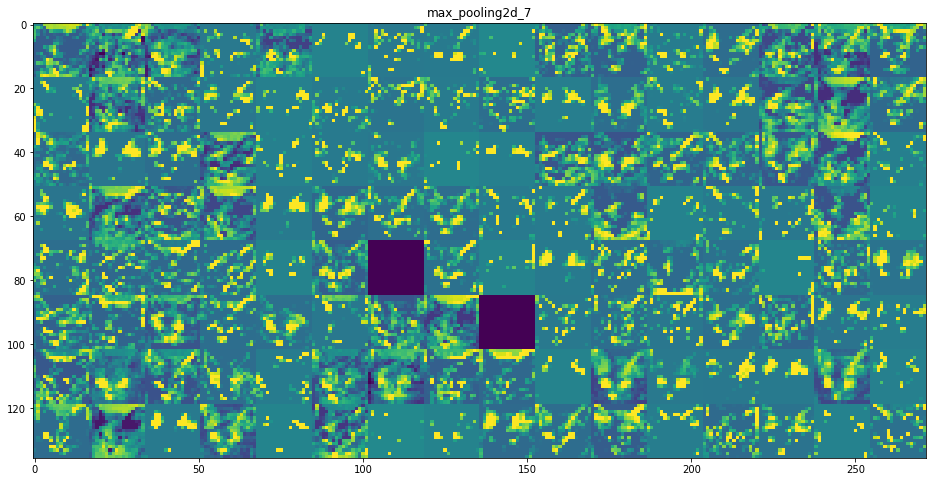

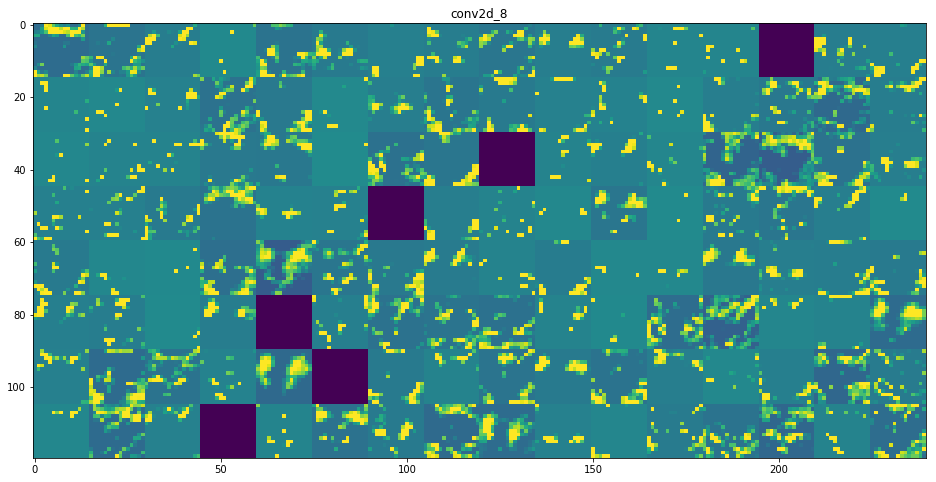

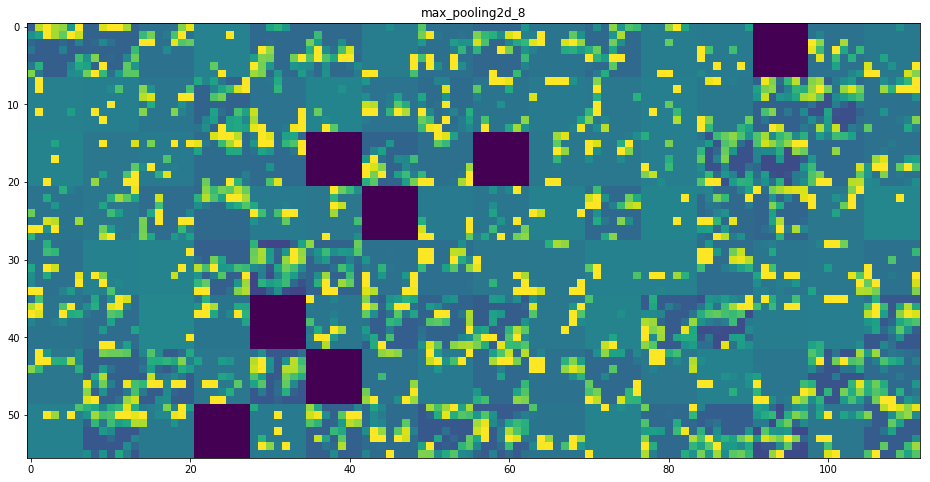

In [11]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

몇 가지 주목할 내용이 있습니다:

* 첫 번째 층은 여러 종류의 에지 감지기를 모아 놓은 것 같습니다. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지됩니다.
* 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워집니다. '고양이 귀'와 '고양이 눈'과 같이 고수준의 개념을 인코딩하기 시작합니다. 상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가합니다.
* 비어 있는 활성화가 층이 깊어짐에 따라 늘어납니다. 첫 번째 층에서는 모든 필터가 입력 이미지에 활성화되었지만 층을 올라가면서 활성화되지 않는 필터들이 생깁니다. 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미입니다.

심층 신경망이 학습한 표현에서 일반적으로 나타나는 중요한 특징을 조금 전 확인했습니다. 층에서 추출한 특성은 층의 깊이를 따라 점점 더 추상적이 됩니다. 높은 층의 활성화는 특정 입력에 관한 시각적 정보가 점점 줄어들고 타깃에 관한 정보(이 경우에는 강아지 또는 고양이 이미지의 클래스)가 점점 더 증가합니다. 심층 신경망은 입력되는 원본 데이터(여기서는 RGB 포맷의 사진)에 대한 정보 정제 파이프라인처럼 작동합니다. 반복적인 변환을 통해 관계없는 정보(예를 들어 이미지에 있는 특정 요소)를 걸러내고 유용한 정보는 강조되고 개선됩니다(여기에서는 이미지의 클래스).

사람과 동물이 세상을 인지하는 방식이 이와 비슷합니다. 사람은 몇 초동안 한 장면을 보고 난 후에 그 안에 있었던 추상적인 물체(자전거, 나무)를 기억할 수 있습니다. 하지만 이 물체의 구체적인 모양을 기억하지 못합니다. 사실 기억을 더듬어 일반적인 자전거를 그려보면 평생 수천 개의 자전거를 보았더라도 조금이라도 비슷하게 그릴 수 없습니다. 실제로 한 번 해보면 진짜 그런지 알 수 있습니다. 우리의 뇌는 시각적 입력에서 관련성이 적은 요소를 필터링하여 고수준의 개념으로 변환합니다. 이렇게 완전히 추상적으로 학습하기 때문에 눈으로 본 것을 자세히 기억하기는 매우 어렵습니다.

## 컨브넷 필터 시각화

컨브넷이 학습한 필터를 조사하는 또 다른 간편한 방법은 각 필터가 반응하는 시각적 패턴을 그려보는 것입니다. 빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화하기 위해 컨브넷 입력 이미지에 경사 상승법을 적용합니다. 결과적으로 입력 이미지는 선택된 필터가 최대로 응답하는 이미지가 될 것입니다.

전체 과정은 간단합니다. 특정 합성곱 층의 한 필터의 값을 최대화하는 손실 함수를 정의합니다. 이 활성화 값을 최대화하기 위해 입력 이미지를 변경하도록 확률적 경사 상승법을 사용합니다. 예를 들어 여기에서는 ImageNet에 사전 훈련된 VGG16 네트워크에서 `block3_conv1` 층의 필터 0번의 활성화를 손실로 정의합니다:

In [11]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

경사 상승법을 구현하기 위해 모델의 입력에 대한 손실의 그래디언트가 필요합니다. 이를 위해 케라스의 `backend` 모듈에 있는 `gradients` 함수를 사용하겠습니다:

In [12]:
# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
grads = K.gradients(loss, model.input)[0]

경사 상승법 과정을 부드럽게 하기 위해 사용하는 한 가지 기법은 그래디언트 텐서를 L2 노름(텐서에 있는 값을 제곱합의 제곱근)으로 나누어 정규화하는 것입니다. 이렇게 하면 입력 이미지에 적용할 수정량의 크기를 항상 일정 범위 안에 놓을 수 있습니다.

In [13]:
# 0 나눗셈을 방지하기 위해 1e–5을 더합니다
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

이제 주어진 입력 이미지에 대해 손실 텐서와 그래디언트 텐서를 계산해야 합니다. 케라스 백엔드 함수를 사용하여 처리하겠습니다. `iterate`는 넘파이 텐서(크기가 1인 텐서의 리스트)를 입력으로 받아 손실과 그래디언트 두 개의 넘파이 텐서를 반환합니다.

In [14]:
iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

여기에서 파이썬 루프를 만들어 확률적 경사 상승법을 구성합니다:

In [15]:
# 잡음이 섞인 회색 이미지로 시작합니다
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다
    input_img_data += grads_value * step

결과 이미지 텐서는 `(1, 150, 150, 3)` 크기의 부동 소수 텐서입니다. 이 텐서의 값은 `[0, 255]` 사이의 정수가 아닙니다. 따라서 출력 가능한 이미지로 변경하기 위해 후처리할 필요가 있습니다. 이를 위해 간단한 함수를 정의해 사용하겠습니다:

In [16]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

이제 모든 코드가 준비되었습니다. 이 코드를 모아서 층의 이름과 필터 번호를 입력으로 받는 함수를 만들겠습니다. 이 함수는 필터 활성화를 최대화하는 패턴을 이미지 텐서로 출력합니다:

In [17]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

이 함수를 실행해 보죠:

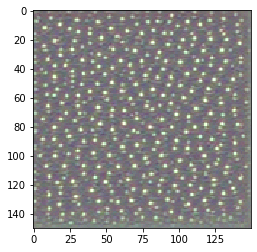

In [18]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

`block3_conv1` 층의 필터 0은 물방울 패턴에 반응하는 것 같습니다.

이제 재미있는 것을 만들어 보죠. 모든 층에 있는 필터를 시각화해보겠습니다. 간단하게 만들기 위해 각 층에서 처음 64개의 필터만 사용하겠습니다. 또 각 합성곱 블럭의 첫 번째 층만 살펴보겠습니다(`block1_conv1`, `block2_conv1`, `block3_conv1`, `block4_conv1`, `block5_conv1`). 여기서 얻은 출력을 64 × 64 필터 패턴의 8 × 8 그리드로 정렬합니다. 각 필터 패턴 사이에 검은 색 마진을 약간 둡니다.

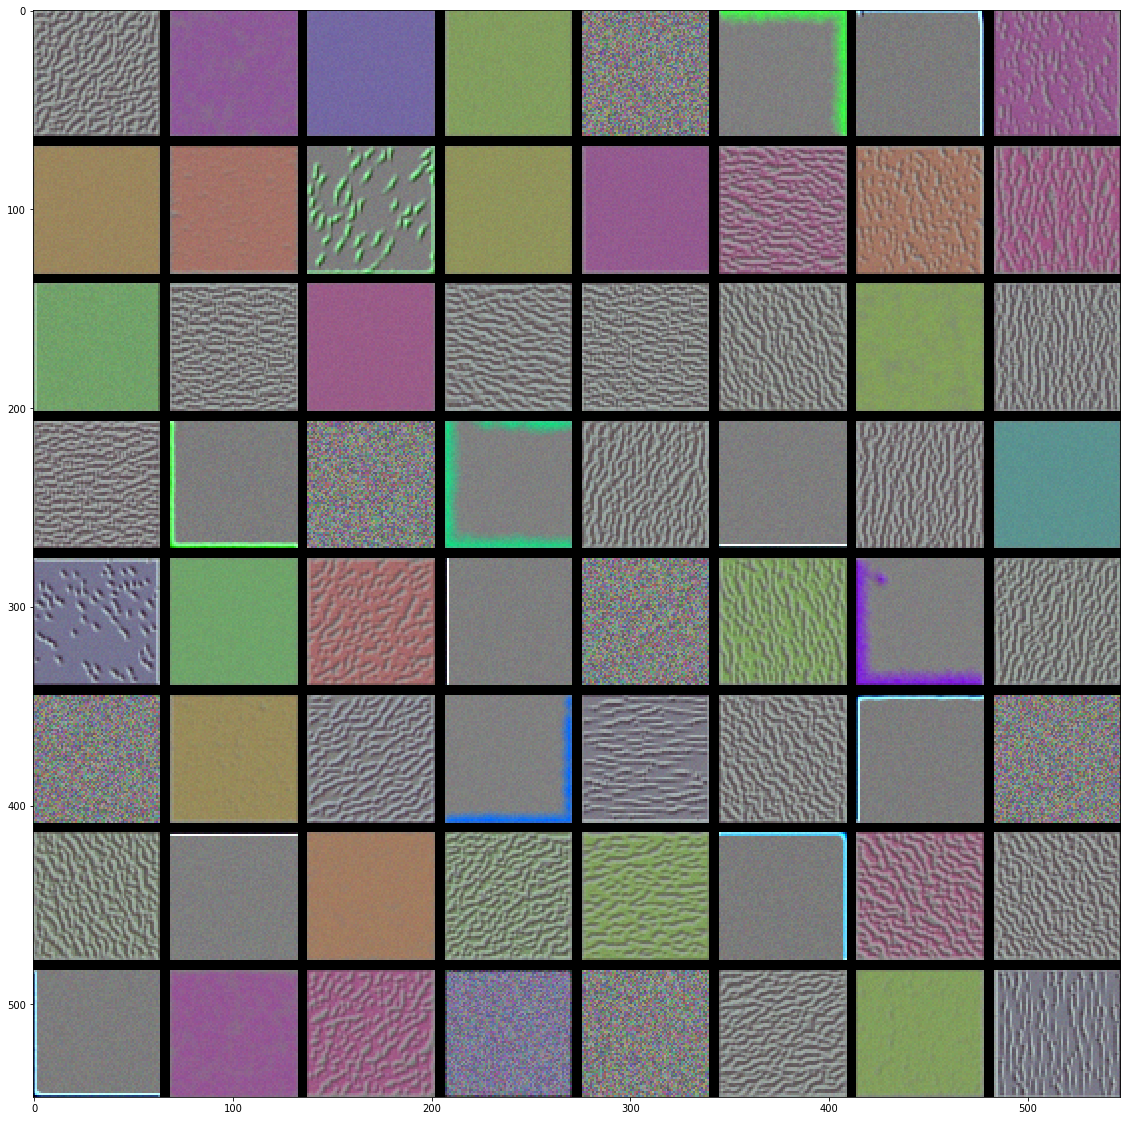

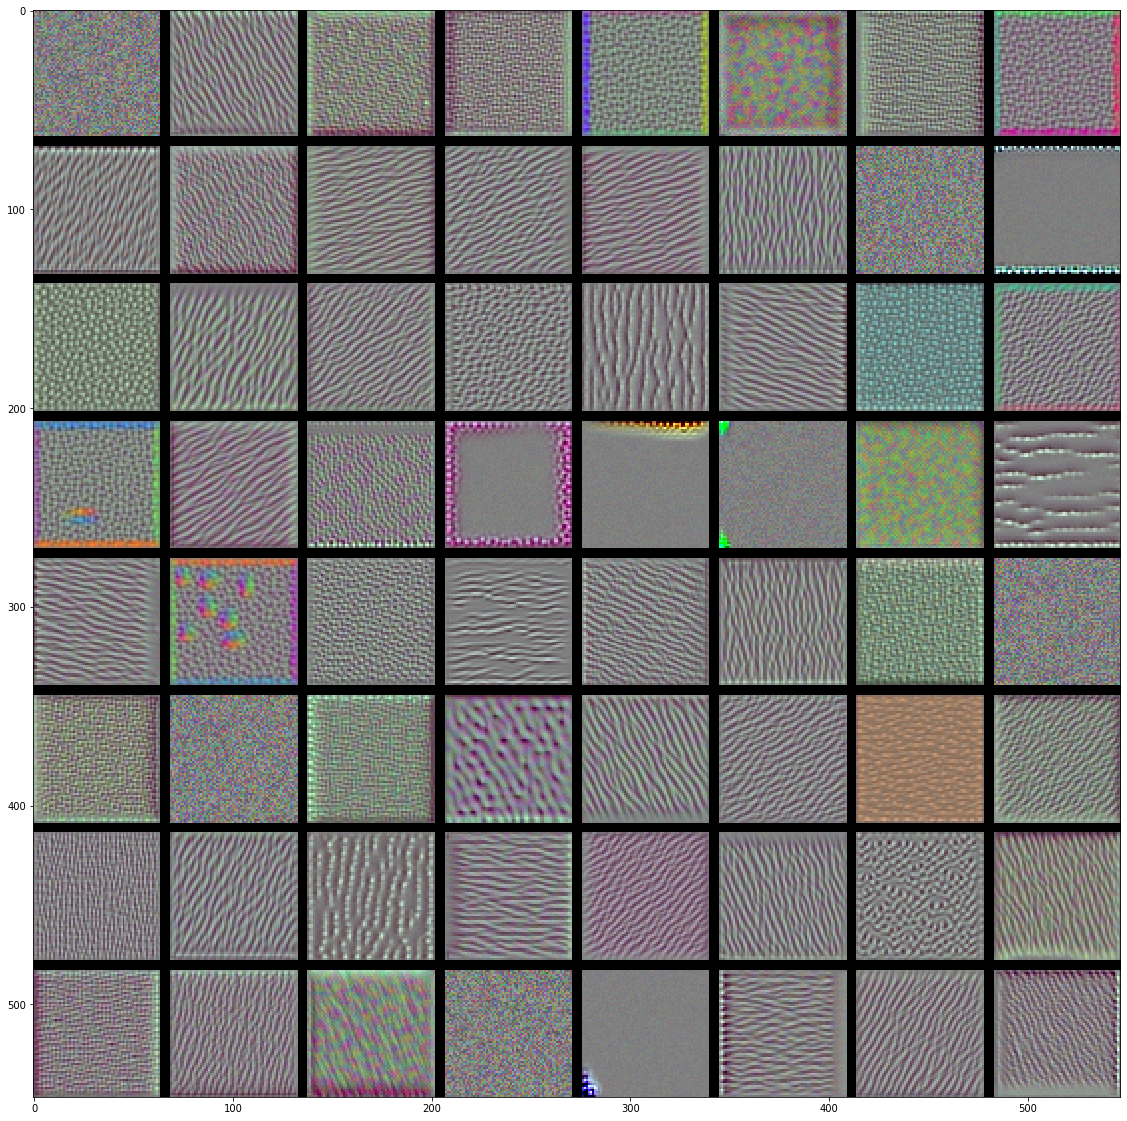

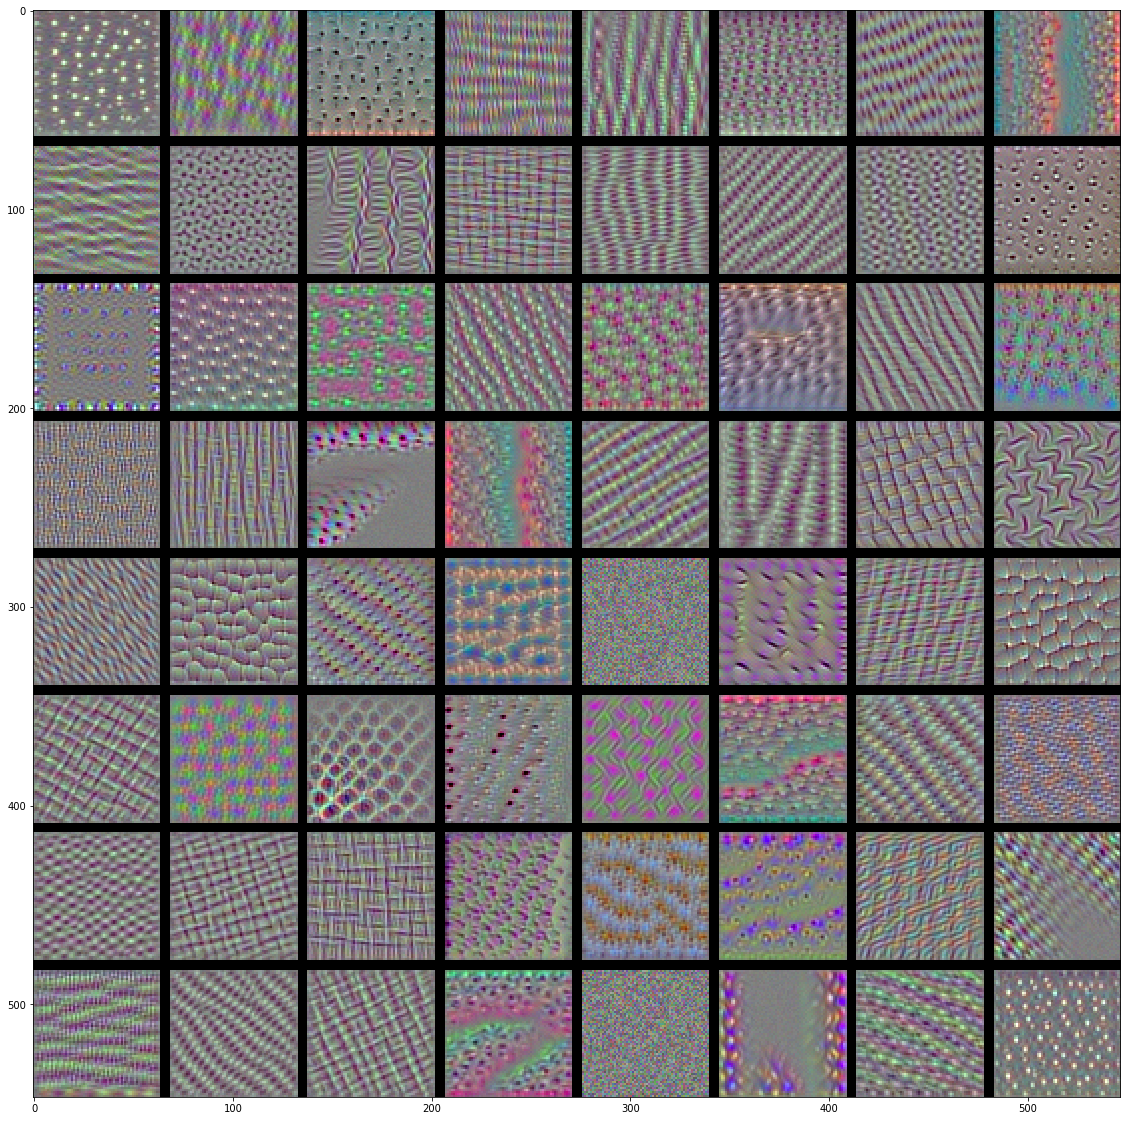

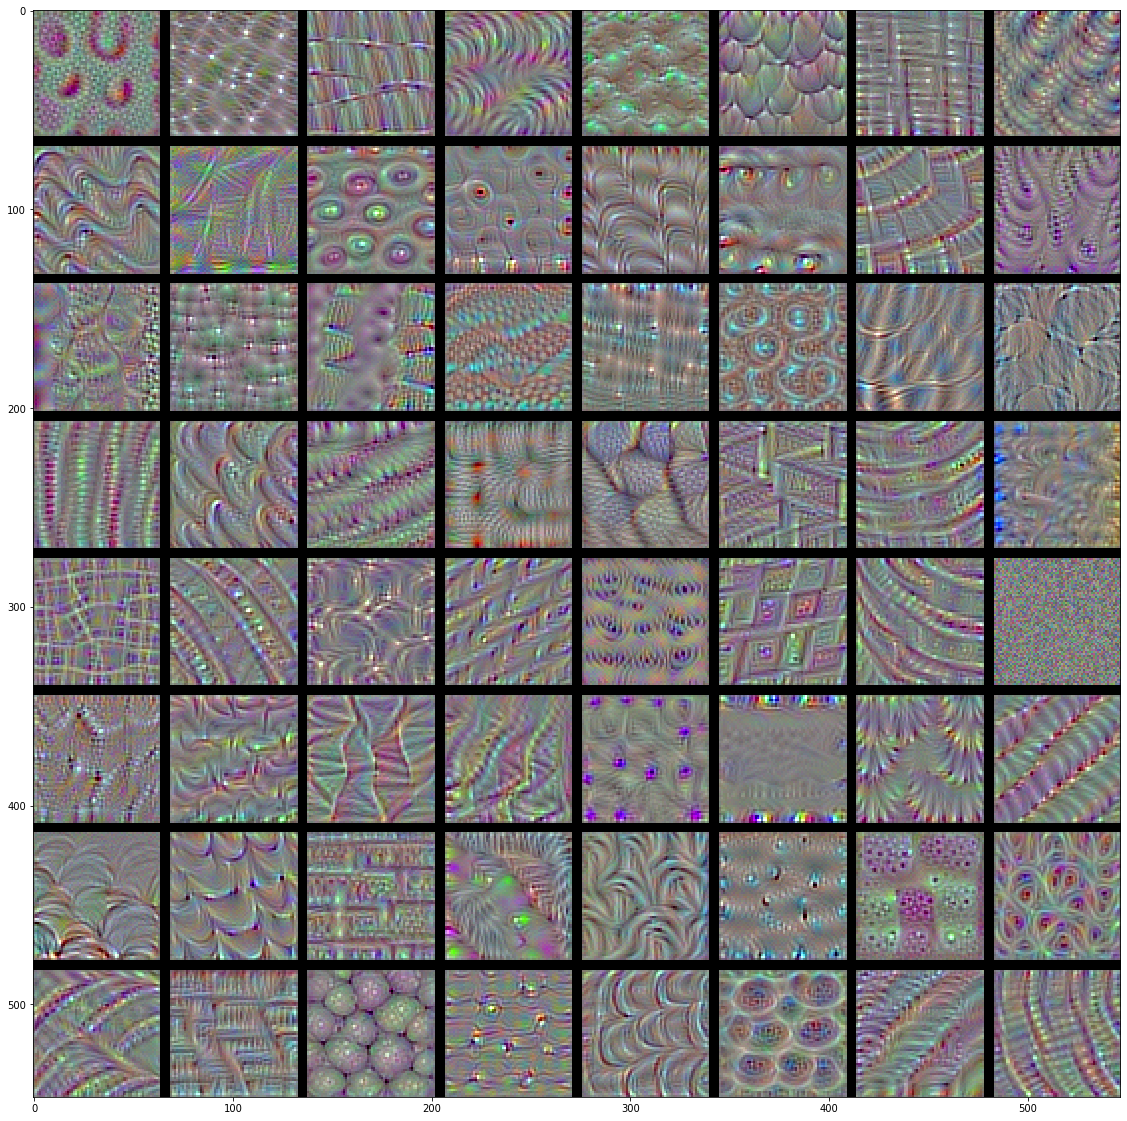

In [19]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 결과를 담을 빈 (검은) 이미지
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):  # results 그리드의 행을 반복합니다
        for j in range(8):  # results 그리드의 열을 반복합니다
            # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # results 그리드의 (i, j) 번째 위치에 저장합니다
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # results 그리드를 그립니다
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

이런 필터 시각화를 통해 컨브넷 층이 바라보는 방식을 이해할 수 있습니다. 컨브넷의 각 층은 필터의 조합으로 입력을 표현할 수 있는 일련의 필터를 학습합니다. 이는 푸리에 변환을 사용해 신호를 일련의 코사인 함수로 분해할 수 있는 것과 비슷합니다. 이 컨브넷 필터들은 모델의 상위 층으로 갈수록 점점 더 복잡해지고 개선됩니다.

* 모델에 있는 첫 번째 층(`block1_conv1`)의 필터는 간단한 대각선 방향의 에지와 색깔(또는 어떤 경우에 색깔이 있는 에지)을 인코딩합니다.
* `block2_conv1`의 필터는 에지나 색깔의 조합으로 만들어진 간단한 질감을 인코딩합니다.
* 더 상위 층의 필터는 깃털, 눈, 나뭇잎 등과 같은 자연적인 이미지에서 찾을 수 있는 질감을 닮아가기 시작합니다.

## 클래스 활성화의 히트맵 시각화하기

한 가지 시각화 기법을 더 소개하겠습니다. 이 방법은 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지 이해하는 데 유용합니다. 분류에 실수가 있는 경우 컨브넷의 결정 과정을 디버깅하는 데 도움이 됩니다. 또한 이미지에 특정 물체가 있는 위치를 파악하는 데 사용할 수도 있습니다.

이 기법의 종류를 일반적으로 클래스 활성화 맵(CAM) 시각화라고 부릅니다. 입력 이미지에 대한 클래스 활성화의 히트맵을 만듭니다. 클래스 활성화 히트맵은 특정 출력 클래스에 대해 입력 이미지의 모든 위치에 대해 계산된 2D 점수 그리드입니다. 클래스에 대해 각 위치가 얼마나 중요한지를 알려 줍니다. 예를 들어 강아지 vs. 고양이 컨브넷에 한 이미지를 주입하면 CAM 시각화는 고양이 클래스에 대한 히트맵을 생성하여 이미지에서 고양이와 비슷한 부분을 알려 줍니다. 강아지 클래스에 대한 히트맵은 이미지에서 강아지와 같은 부분을 알려 줍니다.

여기서 사용할 구체적인 구현은 [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)에 기술되어 있는 것입니다. 이 방법은 매우 간단합니다. 입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출합니다. 그 다음 특성 맵의 모든 채널의 출력에 채널에 대한 클래스의 그래디언트 평균을 곱합니다. 이 기법을 직관적으로 이해하는 방법은 다음과 같습니다. '입력 이미지가 각 채널을 활성화하는 정도'에 대한 공간적인 맵을 '클래스에 대한 각 채널의 중요도'로 가중치를 부여하여 '입력 이미지가 클래스를 활성화하는 정도'에 대한 공간적인 맵을 만드는 것입니다.

사전 훈련된 VGG16 네트워크를 다시 사용하여 이 기법을 시연해 보겠습니다:

In [20]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# 이전 모든 예제에서는 최상단의 완전 연결 분류기를 제외했지만 여기서는 포함합니다
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 144s 0us/step


초원을 걷는 어미와 새끼 아프리카 코끼리의 이미지(크리에이티브 커먼즈(Creative Commons) 라이선스)를 적용해 보겠습니다:


![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

이 이미지를 VGG16 모델이 인식할 수 있도록 변환해보죠. 이 모델은 224 × 224 크기의 이미지에서 훈련되었고 `keras.applications.vgg16.preprocess_input` 함수에 있는 몇 가지 규칙에 따라 전처리 되었습니다. 그러므로 이 이미지를 로드해서 224 × 224 크기로 변경하고 넘파이 float32 텐서로 바꾼 다음 이 전처리 함수를 적용해야 합니다.

In [21]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# 이미지 경로
img_path = './datasets/creative_commons_elephant.jpg'

# 224 × 224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다
img = image.load_img(img_path, target_size=(224, 224))

# (224, 224, 3) 크기의 넘파이 float32 배열
x = image.img_to_array(img)

# 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 변환합니다
x = np.expand_dims(x, axis=0)

# 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
x = preprocess_input(x)

In [22]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 1us/step
Predicted: [('n02504458', 'African_elephant', 0.9101744), ('n01871265', 'tusker', 0.08544522), ('n02504013', 'Indian_elephant', 0.0043368954)]


이 이미지에 대한 상위 세 개의 예측 클래스는 다음과 같습니다.

* 아프리카 코끼리 (92.5% 확률)
* 코끼리(tusker) (7% 확률)
* 인도 코끼리 (0.4% 확률)

네트워크는 이 이미지가 아프리카 코끼리를 담고 있다고 인식했습니다. 예측 벡터에서 최대로 활성화된 항목은 '아프리카 코끼리' 클래스에 대한 것으로 386번 인덱스입니다:

In [23]:
np.argmax(preds[0])

386

이미지에서 가장 아프리카 코끼리 같은 부위를 시각화하기 위해 Grad-CAM 처리 과정을 구현하겠습니다:

In [24]:
# 예측 벡터의 '아프리카 코끼리' 항목
african_elephant_output = model.output[:, 386]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

시각화를 위해 히트맵을 0과 1 사이로 정규화하겠습니다. 최종 결과는 그림 5-35와 같습니다:

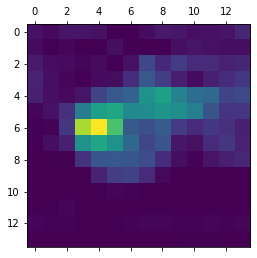

In [25]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

마지막으로 OpenCV를 사용해 앞에서 얻은 히트맵에 원본 이미지를 겹친 이미지를 만들겠습니다:

In [26]:
import cv2

# cv2 모듈을 사용해 원본 이미지를 로드합니다
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경합니다
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도입니다
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장합니다
cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

True

![elephant cam](./datasets/elephant_cam.jpg)

이 시각화 기법은 두 개의 중요한 질문에 대한 답을 줍니다:

* 왜 네트워크가 이 이미지에 아프리카 코끼리가 있다고 생각하는가?
* 아프리카 코끼리가 사진 어디에 있는가?

특히 코끼리 새끼의 귀가 강하게 활성화된 점이 흥미롭습니다. 아마도 이것은 네트워크가 아프리카 코끼리와 인도 코끼리의 차이를 구분하는 방법일 것입니다.